### 0.パッケージのインストール

In [1]:
import sys
import os
sys.path.append("../src")

import torch
import matplotlib.pyplot as plt
import numpy as np

from dataset import CustomSegmentationDataset
from utils import DatasetSplitter
from model import get_deeplabv3plus
from train import train_model
from infer import inference
from convert_to_json import mask_to_json

### 2. データセットの準備・可視化

In [2]:
## 学習用データを分割して学習用(train)と評価用(val)に分ける
splitter = DatasetSplitter(
    image_dir="../data/raw_train/images",
    annotation_file="../data/raw_train/annotations/train_segmentation_annotations.json",
    output_dir="../data"
)

splitter.split(test_size=0.2)

✅ Split completed. Train: 2122, Val: 531


In [3]:
# ファイル読み込み先の指定
train_img_dir = "../data/train/images"
train_ann_file = "../data/train/annotations/annotations.json"
val_img_dir = "../data/val/images"
val_ann_file = "../data/val/annotations/annotations.json"

# annotationラベルの指定
label_map = {
    "background": 0,
    "vacant_lot": 1,
}

train_dataset = CustomSegmentationDataset(train_img_dir, train_ann_file, label_map)
val_dataset = CustomSegmentationDataset(val_img_dir, val_ann_file, label_map)

In [4]:
# サンプル画像とマスクの可視化
idx = 1

img, mask = train_dataset[idx]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()


d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


AttributeError: 'CustomSegmentationDataset' object has no attribute 'target_size'

### 3. モデルの構築

In [5]:
num_classes = 2  # クラス数に応じて変更
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3plus(num_classes).to(device)

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 4.学習

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

num_epochs = 10
model, history = train_model(model, train_loader, val_loader, num_epochs=num_epochs, device=device)

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


AttributeError: 'CustomSegmentationDataset' object has no attribute 'target_size'

### 5. 検証データで推論

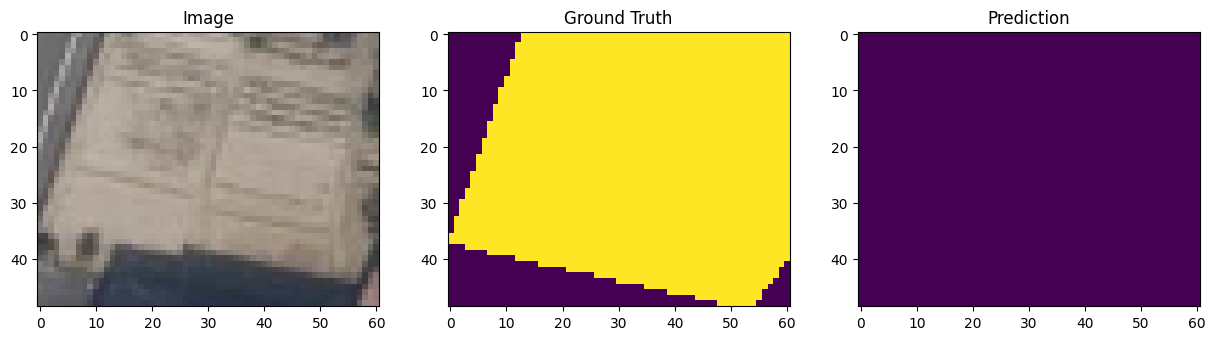

In [12]:
val_img, val_mask = val_dataset[0]
pred_mask = inference(model, val_img, device=device)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(val_img)
plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(val_mask)
plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred_mask)
plt.show()

### 6. 推論結果をJSONで保存

In [13]:
output_json_path = "../data/val/annotations/prediction_0.json"
mask_to_json(pred_mask, output_json_path)
print(f"Saved: {output_json_path}")

Saved: ../data/val/annotations/prediction_0.json


### 7. 追加：学習曲線の可視化（任意）

In [14]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined